# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from pycox.datasets import nwtco
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [3]:
df_train = nwtco.read_df(processed=False)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.shape

(2578, 10)

In [5]:
df_train.head()

rownames  seqno  instit  histol  stage  study  age  in.subcohort  edrel  \
3         4      4       2       1      4      3   28          True   6200   
4         5      5       2       2      2      3   55         False   1244   
5         6      6       1       1      2      3   32         False   2932   
6         7      7       1       1      4      3   45         False    324   
7         8      8       1       1      2      3   44         False   5408   

   rel  
3    0  
4    0  
5    0  
6    1  
7    0

## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [6]:
# 将sex列转换为分类变量
df_train['in.subcohort'] = df_train['in.subcohort'].astype('category').cat.codes
df_train = df_train.iloc[:, 1:]
df_train.head()

seqno  instit  histol  stage  study  age  in.subcohort  edrel  rel
3      4       2       1      4      3   28             1   6200    0
4      5       2       2      2      3   55             0   1244    0
5      6       1       1      2      3   32             0   2932    0
6      7       1       1      4      3   45             0    324    1
7      8       1       1      2      3   44             0   5408    0

In [7]:
cols_leave = ['seqno', 'instit', 'stage', 'study', 'in.subcohort']
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(leave)

In [8]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [9]:
get_target = lambda df: (df['edrel'].values, df['rel'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerSurvival(nn.Module):
    def __init__(self, in_features, num_nodes=[32, 32], out_features=1, 
                 nhead=4, num_layers=2, dropout=0.1, batch_norm=True, output_bias=False):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Linear(in_features, num_nodes[0])
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, num_nodes[0]))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=num_nodes[0],
            nhead=nhead,
            dim_feedforward=num_nodes[0] * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Batch norm
        self.bn = nn.BatchNorm1d(num_nodes[0]) if batch_norm else nn.Identity()
        
        # Output network
        output_layers = []
        prev_dim = num_nodes[0]
        
        for dim in num_nodes[1:]:
            output_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim
        
        output_layers.append(nn.Linear(prev_dim, out_features, bias=output_bias))
        self.output_net = nn.Sequential(*output_layers)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input processing
        x = self.input_proj(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Transformer processing
        x = x.unsqueeze(1) + self.pos_encoding
        x = self.transformer(x).squeeze(1)
        
        # Output
        return self.output_net(x)


# 简洁的创建函数
def create_transformer_network(in_features, num_nodes, out_features, 
                              batch_norm=True, dropout=0.1, output_bias=False,
                              nhead=4, num_layers=1):
    """创建Transformer生存网络"""
    return TransformerSurvival(
        in_features=in_features,
        num_nodes=num_nodes,
        out_features=out_features,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout,
        batch_norm=batch_norm,
        output_bias=output_bias
    )

In [11]:
# 使用方式
in_features = x_train.shape[1]
num_nodes = [16, 16]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False
net = create_transformer_network(in_features, num_nodes,out_features)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [12]:
model = CoxPH(net, tt.optim.Adam)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [13]:
batch_size = 256
model.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torchtuples")

In [15]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 5.1769,	val_loss: 5.1787
1:	[0s / 0s],		train_loss: 5.1917,	val_loss: 5.1789
2:	[0s / 0s],		train_loss: 5.1799,	val_loss: 5.1793
3:	[0s / 0s],		train_loss: 5.1783,	val_loss: 5.1809
4:	[0s / 0s],		train_loss: 5.1764,	val_loss: 5.1807
5:	[0s / 0s],		train_loss: 5.1641,	val_loss: 5.1797
6:	[0s / 0s],		train_loss: 5.1996,	val_loss: 5.1803
7:	[0s / 0s],		train_loss: 5.1958,	val_loss: 5.1783
8:	[0s / 0s],		train_loss: 5.1774,	val_loss: 5.1779
9:	[0s / 0s],		train_loss: 5.1803,	val_loss: 5.1786
10:	[0s / 0s],		train_loss: 5.1773,	val_loss: 5.1788
11:	[0s / 0s],		train_loss: 5.1816,	val_loss: 5.1789
12:	[0s / 0s],		train_loss: 5.1789,	val_loss: 5.1788
13:	[0s / 0s],		train_loss: 5.1872,	val_loss: 5.1801
14:	[0s / 0s],		train_loss: 5.1688,	val_loss: 5.1787
15:	[0s / 0s],		train_loss: 5.1784,	val_loss: 5.1787
16:	[0s / 0s],		train_loss: 5.1863,	val_loss: 5.1793
17:	[0s / 0s],		train_loss: 5.1683,	val_loss: 5.1791
18:	[0s / 0s],		train_loss: 5.1821,	val_loss: 5.1802
CPU

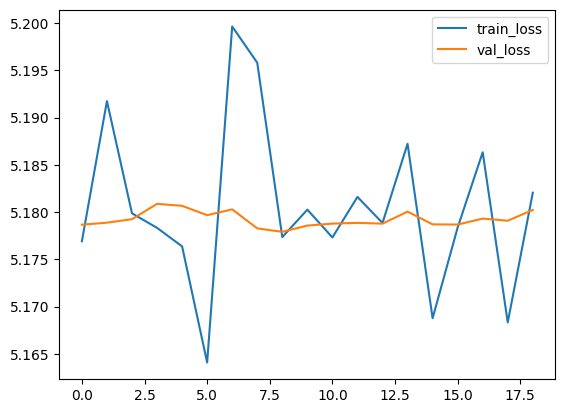

In [16]:
_ = log.plot()

We can get the partial log-likelihood

In [17]:
model.partial_log_likelihood(*val).mean()

-6.3228617

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [18]:
_ = model.compute_baseline_hazards()

In [19]:
surv = model.predict_surv_df(x_test)

In [20]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [21]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [22]:
ev.concordance_td()

0.5245382585751979

In [23]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [24]:
ev.integrated_brier_score(time_grid)

0.1169163460687671

In [25]:
ev.integrated_nbll(time_grid)

0.3940914834443647